# KNN imputation and Linear Regression to predict ranks

This code works extensively with lap time data stored in multiple CSV files. It starts by reading these files and converts lap time strings into seconds, organizing the information to find the fastest odd and even laps. It does data cleaning by deleting rows with missing values in certain columns. Then, it calculates and appends columns for the average fastest lap times, sorting the data accordingly.

Moving on, it merges multiple DataFrames based on common columns ('Namn', 'Klubb') to create a comprehensive ranked DataFrame, ensuring there are no duplicates in the final output.

It further performs missing value imputation using KNN and creates a Linear Regression model to predict 'Predicted_Rank' based on existing ranking columns. After sorting and assigning ranks based on these predictions, it merges new event information with the ranked DataFrame, sorts it based on seeding, and exports the final seeded information to a new CSV file.

In essence, this code intricately processes lap time data, performs data wrangling, analysis, prediction, and merges multiple datasets to provide a comprehensive seeding system for events based on predicted rankings.

In [218]:
import os
import re
import pandas as pd
import numpy as np

In [219]:
# Folder containing CSV files
folder_path = '../src/lap_times_fixed/'

# List all files in the folder ending with '.csv'
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize a dictionary to store dataframes
dataframes = {}

# Loop through each file and read its data into a pandas DataFrame
for file_path in file_paths:
    # Extract file name without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Read CSV into a dataframe and store it in the dictionary
    dataframes[file_name] = pd.read_csv(file_path)

## Check dataframe content

In [220]:
dataframes['Dataframe_1'].head()

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6
0,FMCK Skövde,2023,1.0,Motion 40-49,1111,Magnus Edberg,Huskvarna MK,4,53:05.5,14:08.2,14:17.5,11:47.5,12:52.1,NaN,NaN
1,FMCK Skövde,2023,2.0,Motion -39,518,Alexander Fält,Försvarsmaktens EK,4,53:45.2,14:38.8,14:31.4,12:13.6,12:21.2,NaN,NaN
2,FMCK Skövde,2023,3.0,Motion -39,577,Måns Dalén,FMCK Skövde,4,53:51.5,14:20.4,14:53.3,12:03.4,12:34.3,NaN,NaN
3,FMCK Skövde,2023,4.0,Ungdom E1,175,William Almén,SMK Värnamo,4,54:06.2,14:26.6,14:50.0,12:07.0,12:42.5,NaN,NaN
4,FMCK Skövde,2023,5.0,Motion 40-49,944,Niklas Strömberg,Götene MK,4,54:13.8,14:40.2,15:07.9,11:56.7,12:28.9,NaN,NaN


## Convert lap times to time seconds format.

In [221]:
# Function to convert lap time strings to seconds
def convert_to_seconds(lap_time):
    if pd.notnull(lap_time) and isinstance(lap_time, str) and ':' in lap_time:
        minutes, rest = lap_time.split(':')
        seconds_tenths = rest.split('.')
        if len(seconds_tenths) == 2:
            seconds, tenths = map(int, seconds_tenths)
            total_seconds = int(minutes) * 60 + seconds + tenths / 10
            return total_seconds
    return pd.NaT if pd.notnull(lap_time) else pd.NaT

# Apply the conversion function to lap time columns
for df_name in dataframes:
    varv_columns = [col for col in dataframes[df_name].columns if col.startswith('Varv ')]
    for col in varv_columns:
        dataframes[df_name][col] = dataframes[df_name][col].apply(convert_to_seconds)
        dataframes[df_name][col] = dataframes[df_name][col].replace({'KÖR': pd.NaT, 'BRUTIT': pd.NaT})


In [222]:
dataframes['Dataframe_1'].head()

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6
0,FMCK Skövde,2023,1.0,Motion 40-49,1111,Magnus Edberg,Huskvarna MK,4,53:05.5,848.2,857.5,707.5,772.1,NaT,NaT
1,FMCK Skövde,2023,2.0,Motion -39,518,Alexander Fält,Försvarsmaktens EK,4,53:45.2,878.8,871.4,733.6,741.2,NaT,NaT
2,FMCK Skövde,2023,3.0,Motion -39,577,Måns Dalén,FMCK Skövde,4,53:51.5,860.4,893.3,723.4,754.3,NaT,NaT
3,FMCK Skövde,2023,4.0,Ungdom E1,175,William Almén,SMK Värnamo,4,54:06.2,866.6,890.0,727.0,762.5,NaT,NaT
4,FMCK Skövde,2023,5.0,Motion 40-49,944,Niklas Strömberg,Götene MK,4,54:13.8,880.2,907.9,716.7,748.9,NaT,NaT


## Find fastest lap time in odd Varv columns

In [223]:
# Function to find the fastest lap time from odd-numbered "Varv " columns
def fastest_odd_lap(row):
    odd_varv_cols = [col for col in row.index if col.startswith('Varv ') and int(col.split()[-1]) % 2 != 0]
    odd_lap_times = [row[col] for col in odd_varv_cols if not pd.isnull(row[col])]
    if odd_lap_times:
        return min(odd_lap_times)
    return np.nan  # or pd.NaT if preferred

# Iterate through all Dataframes and add the "FastestOddLap" column
for df_name, df in dataframes.items():
    df['FastestOddLap'] = df.apply(fastest_odd_lap, axis=1)


In [224]:
dataframes['Dataframe_1'].head()

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6,FastestOddLap
0,FMCK Skövde,2023,1.0,Motion 40-49,1111,Magnus Edberg,Huskvarna MK,4,53:05.5,848.2,857.5,707.5,772.1,NaT,NaT,707.5
1,FMCK Skövde,2023,2.0,Motion -39,518,Alexander Fält,Försvarsmaktens EK,4,53:45.2,878.8,871.4,733.6,741.2,NaT,NaT,733.6
2,FMCK Skövde,2023,3.0,Motion -39,577,Måns Dalén,FMCK Skövde,4,53:51.5,860.4,893.3,723.4,754.3,NaT,NaT,723.4
3,FMCK Skövde,2023,4.0,Ungdom E1,175,William Almén,SMK Värnamo,4,54:06.2,866.6,890.0,727.0,762.5,NaT,NaT,727.0
4,FMCK Skövde,2023,5.0,Motion 40-49,944,Niklas Strömberg,Götene MK,4,54:13.8,880.2,907.9,716.7,748.9,NaT,NaT,716.7


## Find fastest lap time in even Varv columns

In [225]:
# Function to find the fastest lap time from even-numbered "Varv " columns
def fastest_even_lap(row):
    even_varv_cols = [col for col in row.index if col.startswith('Varv ') and int(col.split()[-1]) % 2 == 0]
    even_lap_times = [row[col] for col in even_varv_cols if not pd.isnull(row[col])]
    if even_lap_times:
        return min(even_lap_times)
    return np.nan  # or pd.NaT if preferred

# Iterate through all Dataframes and add the "FastestEvenLap" column
for df_name, df in dataframes.items():
    df['FastestEvenLap'] = df.apply(fastest_even_lap, axis=1)


In [226]:
dataframes['Dataframe_1'].head(-10)

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6,FastestOddLap,FastestEvenLap
0,FMCK Skövde,2023,1.0,Motion 40-49,1111,Magnus Edberg,Huskvarna MK,4,53:05.5,848.2,857.5,707.5,772.1,NaN,NaN,707.5,772.1
1,FMCK Skövde,2023,2.0,Motion -39,518,Alexander Fält,Försvarsmaktens EK,4,53:45.2,878.8,871.4,733.6,741.2,NaN,NaN,733.6,741.2
2,FMCK Skövde,2023,3.0,Motion -39,577,Måns Dalén,FMCK Skövde,4,53:51.5,860.4,893.3,723.4,754.3,NaN,NaN,723.4,754.3
3,FMCK Skövde,2023,4.0,Ungdom E1,175,William Almén,SMK Värnamo,4,54:06.2,866.6,890.0,727.0,762.5,NaN,NaN,727.0,762.5
4,FMCK Skövde,2023,5.0,Motion 40-49,944,Niklas Strömberg,Götene MK,4,54:13.8,880.2,907.9,716.7,748.9,NaN,NaN,716.7,748.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,FMCK Skövde,2023,75.0,Bredd,212,Melker Djurstedt,Djursdala SK,5,38:00.3,1085.6,1127.6,1168.8,1266.1,1232.0,NaN,1085.6,1127.6
357,FMCK Skövde,2023,76.0,Junior,134,Max Nordmark,Varbergs MK,5,41:12.0,1083.4,1216.0,1180.8,1465.6,1126.0,NaN,1083.4,1216.0
358,FMCK Skövde,2023,77.0,Bredd,336,Andreas Johansson,Carlsborgs MK,4,55:53.0,773.4,825.7,803.5,950.3,NaT,NaN,773.4,825.7
359,FMCK Skövde,2023,78.0,Bredd,269,Albin Bäckström Herbertsson,Säffle MCK,4,04:29.8,912.4,974.6,922.8,1059.8,NaT,NaN,912.4,974.6


## Drop rows that don't have enough data.

In [227]:
# Delete rows with missing values in Varv 2 and Varv 3 columns
for df_name, df in dataframes.items():
    columns_to_check = ['Varv 2', 'Varv 3']  # Columns Varv 2 and Varv 3 only
    df.dropna(subset=columns_to_check, how='any', inplace=True)

## Check for missing data

In [228]:
# Find and print rows with missing values in FastestOddLap or FastestEvenLap columns
for df_name, df in dataframes.items():
    missing_values = df[df[['FastestOddLap', 'FastestEvenLap']].isnull().any(axis=1)]
    if not missing_values.empty:
        print(f"DataFrame {df_name}: Rows with missing values in FastestOddLap or FastestEvenLap:")
        print(missing_values)
    else:
        print(f"DataFrame {df_name}: No rows with missing values in FastestOddLap or FastestEvenLap.")


DataFrame Dataframe_1: No rows with missing values in FastestOddLap or FastestEvenLap.
DataFrame Dataframe_2: No rows with missing values in FastestOddLap or FastestEvenLap.
DataFrame Dataframe_3: No rows with missing values in FastestOddLap or FastestEvenLap.
DataFrame Dataframe_4: No rows with missing values in FastestOddLap or FastestEvenLap.
DataFrame Dataframe_5: No rows with missing values in FastestOddLap or FastestEvenLap.
DataFrame Dataframe_6: No rows with missing values in FastestOddLap or FastestEvenLap.


## Calculate average of fastest odd and even laps.

In [229]:
# Calculate average of FastestOddLap and FastestEvenLap and add to AvgFastestLap column
for df_name, df in dataframes.items():
    df['AvgFastestLap'] = df[['FastestOddLap', 'FastestEvenLap']].mean(axis=1)


In [230]:
dataframes['Dataframe_1'].head(-10)

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6,FastestOddLap,FastestEvenLap,AvgFastestLap
0,FMCK Skövde,2023,1.0,Motion 40-49,1111,Magnus Edberg,Huskvarna MK,4,53:05.5,848.2,857.5,707.5,772.1,NaN,NaN,707.5,772.1,739.80
1,FMCK Skövde,2023,2.0,Motion -39,518,Alexander Fält,Försvarsmaktens EK,4,53:45.2,878.8,871.4,733.6,741.2,NaN,NaN,733.6,741.2,737.40
2,FMCK Skövde,2023,3.0,Motion -39,577,Måns Dalén,FMCK Skövde,4,53:51.5,860.4,893.3,723.4,754.3,NaN,NaN,723.4,754.3,738.85
3,FMCK Skövde,2023,4.0,Ungdom E1,175,William Almén,SMK Värnamo,4,54:06.2,866.6,890.0,727.0,762.5,NaN,NaN,727.0,762.5,744.75
4,FMCK Skövde,2023,5.0,Motion 40-49,944,Niklas Strömberg,Götene MK,4,54:13.8,880.2,907.9,716.7,748.9,NaN,NaN,716.7,748.9,732.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,FMCK Skövde,2023,71.0,Bredd,234,Patrik Kerttu,Kortedala MK,5,30:23.4,931.7,1021.8,1158.9,1168.5,1142.2,NaN,931.7,1021.8,976.75
353,FMCK Skövde,2023,72.0,Junior,172,Alexander Andersson,Tranemo MK,5,35:10.1,915.5,1196.3,1251.3,1116.3,1230.5,NaN,915.5,1116.3,1015.90
354,FMCK Skövde,2023,73.0,Dam,415,emelie johansson,Götene MK,5,35:10.7,1017.2,1103.7,1107.1,1302.5,1180.1,NaN,1017.2,1103.7,1060.45
355,FMCK Skövde,2023,74.0,Bredd,311,Johan Wolgers,FMCK Borås,5,37:50.4,1039.6,1154.0,1161.9,1373.3,1141.4,NaN,1039.6,1154.0,1096.80


## Sort data on AvgFastestLap columns

In [231]:
# Sort each DataFrame by AvgFastestLap column
for df_name, df in dataframes.items():
    dataframes[df_name] = df.sort_values(by='AvgFastestLap')

In [232]:
dataframes['Dataframe_1'].head(-10)

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,Varv 2,Varv 3,Varv 4,Varv 5,Varv 6,FastestOddLap,FastestEvenLap,AvgFastestLap
282,FMCK Skövde,2023,1.0,Senior,1,Albin Elowson,FMCK Skövde,6,02:44.8,583.3,628.4,594.0,639.4,634.9,684.6,583.3,628.4,605.85
283,FMCK Skövde,2023,2.0,Senior,6,Oskar Ljungström,Falköpings MK,6,05:06.5,601.1,648.1,624.3,666.4,661.3,705.1,601.1,648.1,624.60
284,FMCK Skövde,2023,3.0,Junior,182,Arvid Karlsson,FMCK Skövde,6,07:22.3,646.2,672.8,645.2,685.1,683.1,709.7,645.2,672.8,659.00
285,FMCK Skövde,2023,4.0,Senior,20,Robert Friberg,FMCK Skövde,6,07:31.5,643.4,679.3,647.3,697.5,678.4,705.3,643.4,679.3,661.35
288,FMCK Skövde,2023,7.0,Senior,5,Nisse Bengtsson,Tidaholms MK,6,09:12.2,624.9,698.0,664.1,710.6,689.7,764.6,624.9,698.0,661.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,FMCK Skövde,2023,113.0,Motion 50-59,1473,Håkan Jägmar,Norrahammars MK,4,26:09.5,1308.6,1482.1,1165.3,1213.3,NaN,NaN,1165.3,1213.3,1189.30
134,FMCK Skövde,2023,135.0,Ungdom E1,124,Sam Aronsson,Töreboda MK,4,29:33.2,1765.3,1221.6,1226.8,1159.4,NaN,NaN,1226.8,1159.4,1193.10
255,FMCK Skövde,2023,112.0,Ungdom E0,11,Alicia Isaksson,Falköpings MK,4,22:50.8,1323.1,1207.2,1203.9,1236.6,NaN,NaN,1203.9,1207.2,1205.55
366,FMCK Skövde,2023,85.0,Dam,429,Tilda Mehtonen,FMCK Skövde,3,01:52.7,1030.3,1442.9,1239.5,NaT,NaN,NaN,1030.3,1442.9,1236.60


## Give each rider a rank in a new column.

In [233]:
for key, df in dataframes.items():
    df['Rank'] = range(1, len(df) + 1)

dataframes['Dataframe_2'].head(-10)

,Plats,År,Plac,Klass,#,Namn,Klubb,Varv,Tid,Varv 1,...,Varv 4,Varv 5,Varv 6,Varv 7,Varv 8,Varv 9,FastestOddLap,FastestEvenLap,AvgFastestLap,Rank
356,Tidaholms MK,2023,33.0,Senior,6,Oskar Ljungström,Falköpings MK,8,11:01.5,683.9,...,356.1,714.7,363.1,722.8,364.1,NaT,683.9,349.0,516.45,1
324,Tidaholms MK,2023,1.0,Senior,7,Casper Lindholm,Linköpings MS,9,25:53.3,711.4,...,372.0,744.4,383.3,740.8,369.9,736.3,711.4,359.2,535.30,2
325,Tidaholms MK,2023,2.0,Junior,191,Isac Friman,Tidaholms MK,9,27:03.5,720.9,...,368.4,740.5,405.9,756.1,383.6,755.4,720.9,355.6,538.25,3
397,Tidaholms MK,2023,74.0,Junior,186,Alvin Ceder,Götene MK,5,50:32.1,736.7,...,367.1,801.4,NaT,NaT,NaT,NaT,736.7,362.8,549.75,4
327,Tidaholms MK,2023,4.0,Senior,3,Jesper Börjesson,Tibro MK,9,29:13.2,746.1,...,370.7,791.4,378.6,779.8,373.7,783.8,746.1,357.3,551.70,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Tidaholms MK,2023,156.0,Ungdom E1,124,Sam Aronsson,Töreboda MK,4,06:12.5,1224.6,...,826.5,NaT,NaT,NaT,NaT,NaT,1224.6,649.3,936.95,373
131,Tidaholms MK,2023,132.0,Motion 60-,1510,Stefan Pettersen,Falköpings MK,5,27:28.5,1235.7,...,796.6,1229.1,NaT,NaT,NaT,NaT,1229.1,655.1,942.10,374
395,Tidaholms MK,2023,72.0,Dam,429,Tilda Mehtonen,FMCK Skövde,6,36:59.8,1226.7,...,752.6,1195.6,691.2,NaT,NaT,NaT,1195.6,691.2,943.40,375
130,Tidaholms MK,2023,131.0,Ungdom E0,50,Wilmer Kihlgren,Hjo MK,5,26:58.7,1208.3,...,729.2,1263.0,NaT,NaT,NaT,NaT,1208.3,690.1,949.20,376


## Join all dataframes to one.

In [234]:
# Get the unique 'Namn' values
unique_names = set()
for df in dataframes.values():
    unique_names.update(df['Namn'])

# Create the ranked_dataframe
ranked_dataframe = pd.DataFrame({'Namn': list(unique_names)})

# Merge based on 'Namn' column
for idx, (key, df) in enumerate(dataframes.items(), start=1):
    col_name = df.iloc[0, 0]
    df_subset = df[['Namn', 'Rank', 'Klass', 'Klubb']]
    df_subset = df_subset.rename(columns={'Rank': f'Rank {col_name}', 'Klass': f'Klass_{idx}', 'Klubb': f'Klubb_{idx}'})
    ranked_dataframe = pd.merge(ranked_dataframe, df_subset, on='Namn', how='left')

# Function to merge 'Klass' columns while retaining unique values
def merge_klass(row):
    klasses = [row[f'Klass_{idx}'] for idx in range(1, len(dataframes) + 1)]
    unique_klasses = set(k for k in klasses if pd.notnull(k))
    return ', '.join(unique_klasses)

# Function to merge 'Klubb' columns while retaining unique values
def merge_klubb(row):
    klubbs = [row[f'Klubb_{idx}'] for idx in range(1, len(dataframes) + 1)]
    unique_klubbs = set(k for k in klubbs if pd.notnull(k))
    return ', '.join(unique_klubbs)
    

# Apply the function to create the 'Klass' and 'Klubb' columns in the ranked_dataframe
ranked_dataframe['Klass'] = ranked_dataframe.apply(merge_klass, axis=1)
ranked_dataframe['Klubb'] = ranked_dataframe.apply(merge_klubb, axis=1)

# Drop the individual 'Klass' and 'Klubb' columns for each dataset
for idx in range(1, len(dataframes) + 1):
    ranked_dataframe.drop(f'Klass_{idx}', axis=1, inplace=True)
    ranked_dataframe.drop(f'Klubb_{idx}', axis=1, inplace=True)

ranked_dataframe.head(10)

,Namn,Rank FMCK Skövde,Rank Tidaholms MK,Rank Töreboda MK,Rank Carlsborgs MK,Rank Falköpings MK,Rank Tibro MK,Klass,Klubb
0,Tommy Oldenburg,154.0,264.0,220.0,239.0,214.0,171.0,"Motion 30-39, Motion -39",FMCK Skövde
1,Tomas Sjöquist,164.0,145.0,NaN,NaN,NaN,NaN,Motion 50-59,Försvarsmaktens EK
2,Lars Jansson,NaN,NaN,NaN,NaN,NaN,128.0,Motion 50-59,Karlskoga EK
3,Patrik Kerttu,268.0,NaN,339.0,NaN,NaN,191.0,Bredd,Kortedala MK
4,Olof Backman,NaN,NaN,17.0,NaN,NaN,NaN,Ungdom E1,Karlskoga EK
5,Oskar Geidby,NaN,NaN,NaN,NaN,135.0,NaN,Motion 16-29,MK Nitro
6,Linus Ernstsson,NaN,NaN,96.0,NaN,NaN,66.0,Motion -39,Bengtsfors MCC
7,Peter Damgren,205.0,217.0,227.0,159.0,NaN,NaN,Motion 50-59,FMCK Skövde
8,Max Linder,324.0,276.0,NaN,227.0,NaN,257.0,Ungdom E0,"FMCK Skövde, Tibro MK"
9,Lucas Robinsson,NaN,156.0,NaN,143.0,50.0,NaN,"Junior, Bredd",Falköpings MK


## Drop duplicate rows.
Find duplicate rows based on 'Namn' and 'Klubb' columns.
If no duplicate rows is found show message. Else show what rows where dropped.

In [235]:
duplicate_rows = ranked_dataframe[ranked_dataframe.duplicated(subset=['Namn', 'Klubb'], keep='first')]

# Drop duplicates based on 'Namn' and 'Klubb' columns, keeping the first occurrence (lowest 'AvgRank')
ranked_dataframe.drop_duplicates(subset=['Namn', 'Klubb'], keep='first', inplace=True)

# Display the duplicate rows that were dropped
if duplicate_rows.empty:
    print("No duplicate Rows found")
else:
    print("Duplicate Rows being dropped:")
    print(duplicate_rows)

Duplicate Rows being dropped:
                  Namn  Rank FMCK Skövde  Rank Tidaholms MK  Rank Töreboda MK  \
33        Matilda Huss               NaN                NaN             124.0   
39       Jan-Eric Höög             320.0              286.0             243.0   
43     Roger Jakobsson             160.0              124.0              89.0   
123       Erik Larsson              48.0               42.0              28.0   
124       Erik Larsson              48.0               42.0              28.0   
..                 ...               ...                ...               ...   
758     Jimmy Kaukinen             108.0               65.0              56.0   
784        Per Hedskog             296.0              223.0               NaN   
814    Christer Hedihn             105.0               97.0             105.0   
818  Magnus Ragnarsson             146.0              132.0             106.0   
861   Richard Karlsson              62.0               79.0               NaN  

In [236]:
ranked_dataframe.head(-10)

,Namn,Rank FMCK Skövde,Rank Tidaholms MK,Rank Töreboda MK,Rank Carlsborgs MK,Rank Falköpings MK,Rank Tibro MK,Klass,Klubb
0,Tommy Oldenburg,154.0,264.0,220.0,239.0,214.0,171.0,"Motion 30-39, Motion -39",FMCK Skövde
1,Tomas Sjöquist,164.0,145.0,NaN,NaN,NaN,NaN,Motion 50-59,Försvarsmaktens EK
2,Lars Jansson,NaN,NaN,NaN,NaN,NaN,128.0,Motion 50-59,Karlskoga EK
3,Patrik Kerttu,268.0,NaN,339.0,NaN,NaN,191.0,Bredd,Kortedala MK
4,Olof Backman,NaN,NaN,17.0,NaN,NaN,NaN,Ungdom E1,Karlskoga EK
...,...,...,...,...,...,...,...,...,...
856,Henrik Camitz,NaN,NaN,NaN,NaN,284.0,NaN,Motion 40-49,Grängesbergs MS
857,Nils Jadermark,NaN,NaN,NaN,326.0,NaN,269.0,Motion -39,Karlskoga MF
858,Charlie Turesson,102.0,109.0,NaN,NaN,NaN,NaN,Motion 40-49,FMCK Hässleholm
859,Morgan Pettersson,NaN,NaN,NaN,NaN,NaN,240.0,Bredd,Christinehamns MK


In [237]:
# Initialize a dictionary to hold data for each unique combination of Namn, #, and Klubb
unique_entries = {}

# Iterate through sorted_dataframes
for idx, (key, df) in enumerate(dataframes.items(), start=1):
    col_name = df.iloc[0, 0]
    # Loop through each row in the dataframe
    for index, row in df.iterrows():
        # Create a unique identifier for the combination of Namn, #, and Klubb
        key = (row['Namn'], row['#'], row['Klubb'])
        
        # If the key already exists, update the ranking values for the current dataframe
        if key in unique_entries:
            for col in df.columns:
                if col.startswith('Rank'):
                    unique_entries[key][f'Rank {col_name}'] = min(unique_entries[key].get(f'Rank {col_name}', float('inf')), row[col])
        else:
            # If the key does not exist, create a new entry
            new_entry = {'Namn': row['Namn'], 'Klubb': row['Klubb'], '#': row['#'], 'Klass': row['Klass']}
            for col in df.columns:
                if col.startswith('Rank'):
                    new_entry[f'Rank {col_name}'] = row[col]
            unique_entries[key] = new_entry

# Create a dataframe from the unique_entries dictionary
ranked_dataframe = pd.DataFrame(list(unique_entries.values()))

# Sort the dataframe by 'Namn' or any other desired column
ranked_dataframe.sort_values(by='Namn', inplace=True)

# Display the resulting ranked_dataframe
ranked_dataframe.head(-10)

,Namn,Klubb,#,Klass,Rank FMCK Skövde,Rank Töreboda MK,Rank Tidaholms MK,Rank Falköpings MK,Rank Carlsborgs MK,Rank Tibro MK
6,Adam Fast,SMK Vingåker,78,Senior,7.0,5.0,6.0,8.0,8.0,3.0
459,Agnes Kindgren,SMK Eksjö,454,Motion Dam,NaN,NaN,332.0,NaN,NaN,NaN
243,Albin Bäckström Herbertsson,Säffle MCK,269,Bredd,244.0,NaN,252.0,110.0,NaN,NaN
0,Albin Elowson,FMCK Skövde,1,Senior,1.0,1.0,NaN,NaN,NaN,NaN
238,Albin Glansén,Tidaholms MK,20,Ungdom E0,239.0,191.0,197.0,NaN,176.0,226.0
...,...,...,...,...,...,...,...,...,...,...
229,Wilje Bogren,Töreboda MK,94,Ungdom E0,230.0,NaN,215.0,80.0,190.0,184.0
46,William Almén,SMK Värnamo,175,Ungdom E1,47.0,15.0,26.0,NaN,20.0,29.0
274,William Bengtsson,Tidaholms MK,23,Ungdom E0,275.0,NaN,280.0,NaN,NaN,NaN
356,William Berg,Solshesters MCK,150,Junior,NaN,NaN,30.0,NaN,NaN,NaN


## Check for Missing Values

In [238]:
# Check for missing values in the dataset
missing_values = ranked_dataframe.isnull().sum()
print(missing_values)


Namn                    0
Klubb                   0
#                       0
Klass                   0
Rank FMCK Skövde      476
Rank Töreboda MK      420
Rank Tidaholms MK     437
Rank Falköpings MK    490
Rank Carlsborgs MK    477
Rank Tibro MK         520
dtype: int64


## KNN imputation

In [239]:
from sklearn.impute import KNNImputer

# Instantiate the KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Perform KNN imputation on the DataFrame
imputed_data = imputer.fit_transform(ranked_dataframe.select_dtypes(include=['number']))

# Convert the imputed numpy array back to a DataFrame
columns = ranked_dataframe.select_dtypes(include=['number']).columns
ranked_dataframe_imputed = pd.DataFrame(imputed_data, columns=columns)

# Combine the imputed numerical columns with non-numeric columns if any
non_numeric_columns = ranked_dataframe.select_dtypes(exclude=['number'])
ranked_dataframe_imputed = pd.concat([ranked_dataframe_imputed, non_numeric_columns], axis=1)


In [240]:
ranked_dataframe_imputed.head(-10)

,#,Rank FMCK Skövde,Rank Töreboda MK,Rank Tidaholms MK,Rank Falköpings MK,Rank Carlsborgs MK,Rank Tibro MK,Namn,Klubb,Klass
0,78.0,7.0,5.0,6.0,8.0,8.0,3.0,Albin Elowson,FMCK Skövde,Senior
1,454.0,299.4,323.8,332.0,183.6,275.2,180.6,Oskar Ljungström,Falköpings MK,Senior
2,269.0,244.0,257.6,252.0,110.0,178.2,122.0,Arvid Karlsson,FMCK Skövde,Junior
3,1.0,1.0,1.0,73.6,24.6,27.4,63.0,Robert Friberg,FMCK Skövde,Senior
4,20.0,239.0,191.0,197.0,109.6,176.0,226.0,Nisse Bengtsson,Tidaholms MK,Senior
...,...,...,...,...,...,...,...,...,...,...
809,94.0,230.0,238.6,215.0,80.0,190.0,184.0,Isac Svensson,Vissefjärda EK,Motion -39
810,175.0,47.0,15.0,26.0,11.0,20.0,29.0,Isak Ljungström,Hallsbergs MK,Motion -39
811,23.0,275.0,203.6,280.0,128.0,173.2,113.2,Ulf Johannesson,FMCK Borås,Motion 50-59
812,150.0,70.6,36.4,30.0,22.0,106.2,53.8,Edvin Blad,Oskarshamns MSK,Motion -39


## Using Linear Regression to predict the rank based on the given columns:

In [241]:
from sklearn.linear_model import LinearRegression

# Assuming 'rank_columns' are the columns you want to use for prediction
rank_columns = ['Rank FMCK Skövde', 'Rank Töreboda MK', 'Rank Tidaholms MK', 'Rank Falköpings MK', 'Rank Carlsborgs MK', 'Rank Tibro MK']

# Create a linear regression model
model = LinearRegression()

# Use the values in 'rank_columns' as features
X = ranked_dataframe_imputed[rank_columns]

# Predict 'Predicted_Rank' using the mean of the 'rank_columns' as the target variable
ranked_dataframe_imputed['Predicted_Rank'] = model.fit(X, X.mean(axis=1)).predict(X)

In [242]:
ranked_dataframe_imputed.head(-10)

,#,Rank FMCK Skövde,Rank Töreboda MK,Rank Tidaholms MK,Rank Falköpings MK,Rank Carlsborgs MK,Rank Tibro MK,Namn,Klubb,Klass,Predicted_Rank
0,78.0,7.0,5.0,6.0,8.0,8.0,3.0,Albin Elowson,FMCK Skövde,Senior,6.166667
1,454.0,299.4,323.8,332.0,183.6,275.2,180.6,Oskar Ljungström,Falköpings MK,Senior,265.766667
2,269.0,244.0,257.6,252.0,110.0,178.2,122.0,Arvid Karlsson,FMCK Skövde,Junior,193.966667
3,1.0,1.0,1.0,73.6,24.6,27.4,63.0,Robert Friberg,FMCK Skövde,Senior,31.766667
4,20.0,239.0,191.0,197.0,109.6,176.0,226.0,Nisse Bengtsson,Tidaholms MK,Senior,189.766667
...,...,...,...,...,...,...,...,...,...,...,...
809,94.0,230.0,238.6,215.0,80.0,190.0,184.0,Isac Svensson,Vissefjärda EK,Motion -39,189.600000
810,175.0,47.0,15.0,26.0,11.0,20.0,29.0,Isak Ljungström,Hallsbergs MK,Motion -39,24.666667
811,23.0,275.0,203.6,280.0,128.0,173.2,113.2,Ulf Johannesson,FMCK Borås,Motion 50-59,195.500000
812,150.0,70.6,36.4,30.0,22.0,106.2,53.8,Edvin Blad,Oskarshamns MSK,Motion -39,53.166667


## Sort the DataFrame based on the 'Predicted_Rank' column

In [243]:
ranked_dataframe_imputed.sort_values(by='Predicted_Rank', ascending=True, inplace=True)
ranked_dataframe_imputed.head(-10)

,#,Rank FMCK Skövde,Rank Töreboda MK,Rank Tidaholms MK,Rank Falköpings MK,Rank Carlsborgs MK,Rank Tibro MK,Namn,Klubb,Klass,Predicted_Rank
604,6.0,2.0,7.4,1.0,1.0,7.6,5.6,Marcus Alsing,SMC,Motion 40-49,4.100000
0,78.0,7.0,5.0,6.0,8.0,8.0,3.0,Albin Elowson,FMCK Skövde,Senior,6.166667
684,20.0,4.0,11.0,7.0,7.0,12.0,10.0,Anton Rollborn,Djursdala SK,Motion 30-39,8.500000
288,191.0,13.8,23.0,3.0,6.0,3.0,6.0,Christian Larsson,Ulricehamns MK,Motion 50-59,9.133333
582,5.0,5.0,13.0,10.0,29.2,6.0,9.0,Harald Lindholm,Älvbygdens MK,Motion -39,12.033333
...,...,...,...,...,...,...,...,...,...,...,...
437,451.0,332.0,378.0,349.0,193.6,328.6,236.6,Lars-Gunnar Skogh,Falköpings MK,Motion 60-,302.966667
748,1510.0,342.0,389.0,374.0,168.0,259.8,303.0,Pierre Ferm,SMK Östgöta,Motion 50-59,305.966667
470,983.0,307.0,402.0,339.4,148.2,344.0,298.0,Casper Svahn,Örebro MK,Ungdom E1,306.433333
367,999.0,308.0,394.0,377.0,148.2,339.0,275.0,Inge Edberg,Huskvarna MK,Motion 60-,306.866667


## Create the 'Rank' column using Python's indexing

In [244]:
ranked_dataframe_imputed['Rank'] = range(1, len(ranked_dataframe_imputed) + 1)
ranked_dataframe_imputed.head(-10)

,#,Rank FMCK Skövde,Rank Töreboda MK,Rank Tidaholms MK,Rank Falköpings MK,Rank Carlsborgs MK,Rank Tibro MK,Namn,Klubb,Klass,Predicted_Rank,Rank
604,6.0,2.0,7.4,1.0,1.0,7.6,5.6,Marcus Alsing,SMC,Motion 40-49,4.100000,1
0,78.0,7.0,5.0,6.0,8.0,8.0,3.0,Albin Elowson,FMCK Skövde,Senior,6.166667,2
684,20.0,4.0,11.0,7.0,7.0,12.0,10.0,Anton Rollborn,Djursdala SK,Motion 30-39,8.500000,3
288,191.0,13.8,23.0,3.0,6.0,3.0,6.0,Christian Larsson,Ulricehamns MK,Motion 50-59,9.133333,4
582,5.0,5.0,13.0,10.0,29.2,6.0,9.0,Harald Lindholm,Älvbygdens MK,Motion -39,12.033333,5
...,...,...,...,...,...,...,...,...,...,...,...,...
437,451.0,332.0,378.0,349.0,193.6,328.6,236.6,Lars-Gunnar Skogh,Falköpings MK,Motion 60-,302.966667,810
748,1510.0,342.0,389.0,374.0,168.0,259.8,303.0,Pierre Ferm,SMK Östgöta,Motion 50-59,305.966667,811
470,983.0,307.0,402.0,339.4,148.2,344.0,298.0,Casper Svahn,Örebro MK,Ungdom E1,306.433333,812
367,999.0,308.0,394.0,377.0,148.2,339.0,275.0,Inge Edberg,Huskvarna MK,Motion 60-,306.866667,813


## Save to CSV file.
Save ranked_dataframe_imputed to file.

In [265]:
ranked_dataframe_imputed.to_csv('../src/ranked/ai_ranked.csv', index=False)

## Load participants for new event

In [255]:
file_path = '../src/unseeded/unseeded_motion_40-49.csv'

# Read the CSV file into a DataFrame with the second row as column names
new_event_df = pd.read_csv(file_path, encoding='cp1252', header=0)

# Display the first few rows of the DataFrame
new_event_df.head(-10)

,Tidaholms MK,2024,#,Namn,Klubb
0,NaN,NaN,NaN,Niklas Fransson,Vimmerby MS
1,NaN,NaN,900.0,Hans Torsborn,Ulricehamns MK
2,NaN,NaN,902.0,Peter Berggren,BMK Uddevalla
3,NaN,NaN,903.0,Björn Bäckström,MK Ran
4,NaN,NaN,904.0,Rickard Persson,Tibro MK
...,...,...,...,...,...
66,NaN,NaN,987.0,Christian Johansson,Tidaholms MK
67,NaN,NaN,989.0,David Andersson,MCK Hallandia
68,NaN,NaN,990.0,Johan Kjellson,FMCK Skövde
69,NaN,NaN,991.0,Patrik Förkrök Ledström,SMK Vadstena


## Merge new event details with historical rankings to create seeded list.

In [256]:
# Merge new_event_df with ranked_dataframe_imputed on 'Namn' and 'Klubb' columns
new_event_df = new_event_df.merge(ranked_dataframe_imputed[['Namn', 'Klubb', 'Rank']], how='left', on=['Namn', 'Klubb'])

# Rename the column to 'Seedning' for clarity
new_event_df.rename(columns={'Rank': 'Seedning'}, inplace=True)

# Sort the DataFrame based on the 'Seedning' column in ascending order
new_event_df = new_event_df.sort_values(by='Seedning')

# View the new_event_df with the added 'Seedning' column
new_event_df.head(-10)



,Tidaholms MK,2024,#,Namn,Klubb,Seedning
77,NaN,NaN,995.0,Johan Elfving,Ulricehamns MK,27.0
78,NaN,NaN,996.0,Filip Starck,Norrahammars MK,33.0
37,NaN,NaN,941.0,Fredrik Kron,Falköpings MK,44.0
63,NaN,NaN,980.0,Mark Edvardsson,Alingsås MCK,57.0
6,NaN,NaN,906.0,Anders Billestedt Andersson,Stenungsunds MS,93.0
...,...,...,...,...,...,...
32,NaN,NaN,936.0,Fredrik Erlandsson,Norrahammars MK,NaN
33,NaN,NaN,937.0,David Rudhem,Lidköpings MCK,NaN
39,NaN,NaN,945.0,Markus Björklund,Hjo MK,NaN
40,NaN,NaN,946.0,Jonny Zäll,Hjo MK,NaN


In [258]:
# Sort the DataFrame based on the 'Seedning' column in ascending order
new_event_df = new_event_df.sort_values(by='Seedning')

# Rewrite the 'Seedning' column values
new_event_df['Seedning'] = range(1, len(new_event_df) + 1)
new_event_df.head(-10)

,Tidaholms MK,2024,#,Namn,Klubb,Seedning
77,NaN,NaN,995.0,Johan Elfving,Ulricehamns MK,1
78,NaN,NaN,996.0,Filip Starck,Norrahammars MK,2
37,NaN,NaN,941.0,Fredrik Kron,Falköpings MK,3
63,NaN,NaN,980.0,Mark Edvardsson,Alingsås MCK,4
6,NaN,NaN,906.0,Anders Billestedt Andersson,Stenungsunds MS,5
...,...,...,...,...,...,...
32,NaN,NaN,936.0,Fredrik Erlandsson,Norrahammars MK,73
33,NaN,NaN,937.0,David Rudhem,Lidköpings MCK,74
39,NaN,NaN,945.0,Markus Björklund,Hjo MK,75
40,NaN,NaN,946.0,Jonny Zäll,Hjo MK,76


## Save to CSV file

In [259]:
new_event_df.to_csv('../src/seeded/AI_Seeding.csv', encoding='cp1252', index=False)

---

# Testing some plots.

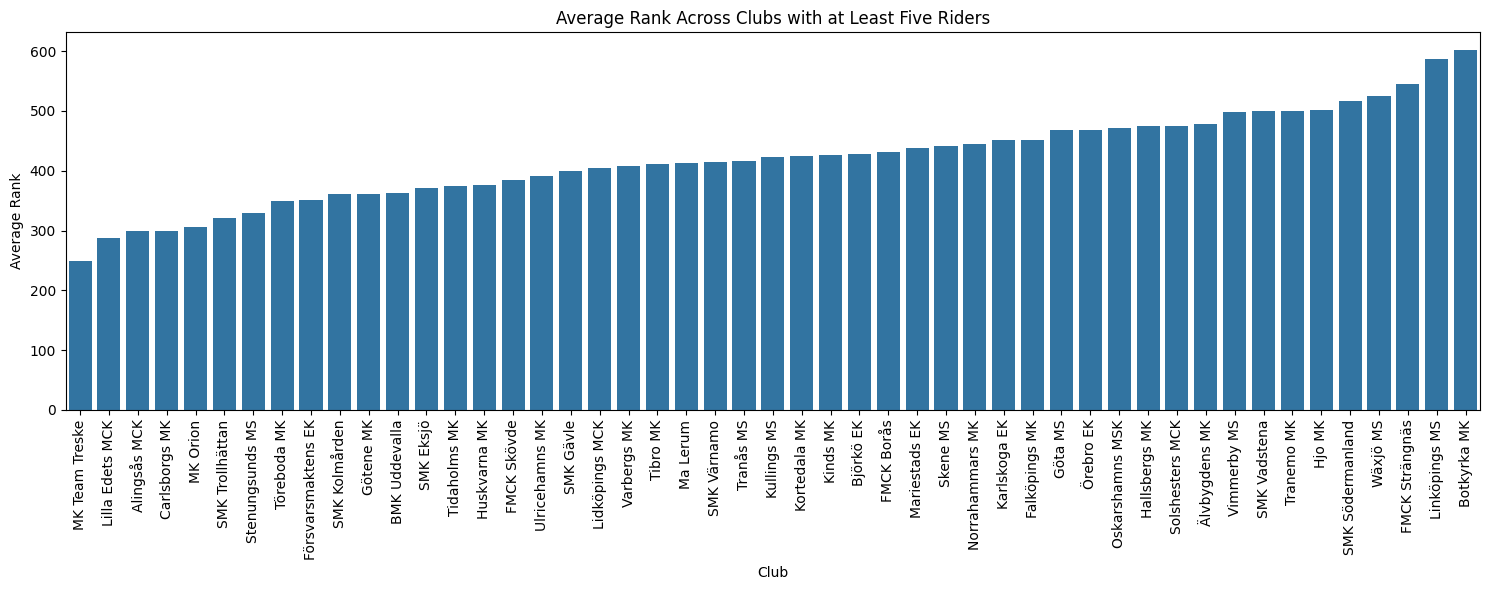

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the count of riders for each club
club_riders_count = ranked_dataframe_imputed['Klubb'].value_counts()

# Filter clubs with at least five riders
clubs_with_five_riders = club_riders_count[club_riders_count >= 5]

# Filter the DataFrame for clubs with at least five riders
filtered_data = ranked_dataframe_imputed[ranked_dataframe_imputed['Klubb'].isin(clubs_with_five_riders.index)]

# Calculate average rank for each club
club_avg_rank = filtered_data.groupby('Klubb')['Rank'].mean().sort_values()

# Create a bar plot showing the average rank for clubs with at least five riders
plt.figure(figsize=(15, 6))
sns.barplot(x=club_avg_rank.index, y=club_avg_rank.values)
plt.title('Average Rank Across Clubs with at Least Five Riders')
plt.xlabel('Club')
plt.ylabel('Average Rank')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [106]:
!pip install dash

   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ------ --------------------------------- 1.7/10.2 MB 36.8 MB/s eta 0:00:01
   ----------- ---------------------------- 2.9/10.2 MB 37.7 MB/s eta 0:00:01
   --------------------- ------------------ 5.4/10.2 MB 37.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.1/10.2 MB 37.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.2 MB 37.7 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.2 MB 36.2 MB/s eta 0:00:01
   ---------------------------------------- 10.2/10.2 MB 32.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/99.7 kB ? eta -:--:--
   ---------------------------------------- 99.7/99.7 kB ? eta 0:00:00


In [107]:
!pip install plotly

In [262]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Load your data (assuming you have the necessary DataFrame named 'ranked_dataframe_imputed')
# Replace this line with your data loading method
# ranked_dataframe_imputed = pd.read_csv('your_data.csv')

# Calculate average rank for each club
club_avg_rank = ranked_dataframe_imputed.groupby('Klubb')['Rank'].mean().sort_values()

# Filter clubs with at least five riders
club_riders_count = ranked_dataframe_imputed['Klubb'].value_counts()
clubs_with_five_riders = club_riders_count[club_riders_count >= 1]
filtered_data = ranked_dataframe_imputed[ranked_dataframe_imputed['Klubb'].isin(clubs_with_five_riders.index)]
club_avg_rank_filtered = filtered_data.groupby('Klubb')['Rank'].mean().sort_values()

# Initialize Dash app
app = dash.Dash(__name__)

# Create layout for the dashboard
app.layout = html.Div([
    html.H1("Interactive Dashboard: Average Rank Across Clubs"),
    dcc.Graph(
        id='club-rank-bar-chart',
        figure=px.bar(x=club_avg_rank_filtered.index, y=club_avg_rank_filtered.values)
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
